# Supervised Semantic Segmentation with Deep CNN

In [0]:
%matplotlib inline

# Switch USE_GPU to True only if you want to use GPU. 
USE_GPU = True

In [0]:
# Python Libraries
import random
import math
import numbers
import platform
import copy

# Importing essential libraries for basic image manipulations.
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# Some of the main PyTorch and TorchVision libraries.
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

# Fully implementated torchvision.datasets.voc (containing popular "Pascal" dataset)
# that allows us to easily create single-image datasets
from lib.voc import VOCSegmentation

# Note class labels used in Pascal dataset:
# 0:    background,
# 1-20: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike,
#       person, pottedplant, sheep, sofa, train, TV_monitor
# 255: "void", which means class for pixel is undefined

In [0]:
!pip3 install chainercv

In [0]:
# ChainerCV is a library similar to TorchVision, created and maintained by Preferred Networks. 
# Chainer, the base library, inspired and led to the creation of PyTorch.
from chainercv.evaluations import eval_semantic_segmentation
from chainercv.datasets import VOCSemanticSegmentationDataset

In [0]:
# This colorize_mask class takes in a numpy segmentation mask,
#  and then converts it to a PIL Image for visualization.
#  Since by default the numpy matrix contains integers from
#  0,1,...,num_classes, we need to apply some color to this
#  so we can visualize easier! Refer to:
#  https://pillow.readthedocs.io/en/4.1.x/reference/Image.html#PIL.Image.Image.putpalette
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

0it [00:00, ?it/s]

1999642624it [06:40, 5488725.02it/s]                                

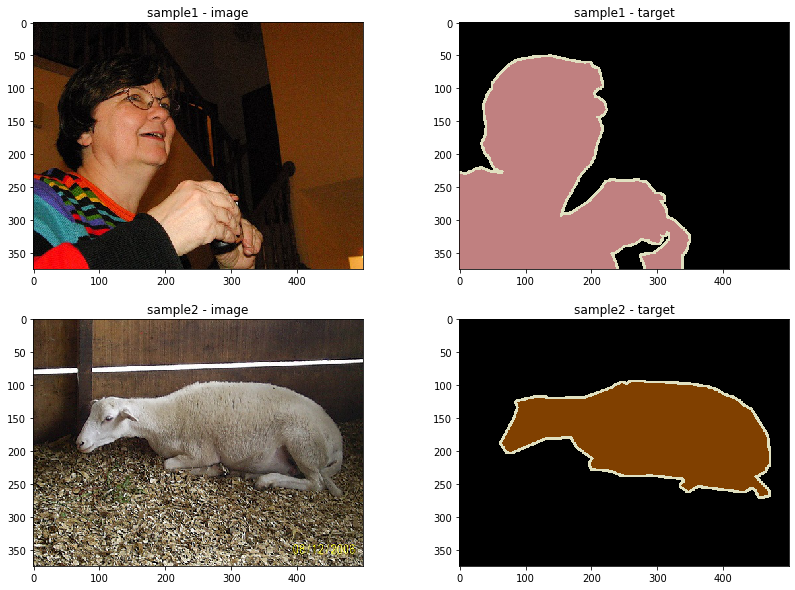

In [0]:
# Running this block will automatically download the PASCAL VOC Dataset (3.7GB) to DATASET_PATH if "download = True".
# The code below creates subdirectory "datasets" in the same location as the notebook file.
# You can modify DATASET_PATH to download the dataset to any custom directory. Download takes a few minutes.
# On subsequent runs you may save time by setting "download = False" (the default value of this flag)

DATASET_PATH = 'datasets'  

# Here, we obtain and visualize one sample (img, target) pair from VOC training dataset and one from validation dataset. 
# Note that operator [...] extracts the sample corresponding to the specified index. 
# Also, note the parameter download = True. Set this to False after you download to save time on later runs.
sample1 = VOCSegmentation(DATASET_PATH, image_set='train', download = True)[200]
sample2 = VOCSegmentation(DATASET_PATH, image_set='val')[20]

# We demonstrate two different (equivalent) ways to access image and target inside the samples.
img1, target1 = sample1
img2 = sample2[0]
target2 = sample2[1]

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('sample1 - image')
ax1.imshow(img1)
ax2 = fig.add_subplot(2,2,2)
plt.title('sample1 - target')
ax2.imshow(target1)
ax3 = fig.add_subplot(2,2,3)
plt.title('sample2 - image')
ax3.imshow(img2)
ax4 = fig.add_subplot(2,2,4)
plt.title('sample2 - target')
ax4.imshow(target2)

## Implement a set of "Joint Transform" functions to perform data augmentations.
Neural networks are typically applied to transformed images. There are several important reasons for this: 

1. The image data should in certain required format (i.e. consistent spacial resolution to batch). The images should also be normalized and converted to the "tensor" data format expected by pytorch libraries. 

2. Some transforms are used to perform randomized image domain transformations with the purpose of "data augmentation". 

In this part, we implement a set of different transform functions to do both of these things. Note that unlike classification nets, training semantic segmentation networks requires that some of the transforms are applied to both image and the corresponding "target" (Ground Truth segmentation mask). We refer to such transforms and their compositions as "Joint". In general, our Transform classes take as the input both the image and the target, and return a tuple of the transformed input image and target.

In [0]:
class JointToTensor(object):
    def __call__(self, img, target):
        return tF.to_tensor(img), torch.from_numpy(np.array(target.convert('P'), dtype=np.int32)).long()

In [0]:
# Check the transform by passing the image-target sample.
JointToTensor()(*sample1)

#### JointCenterCrop: 

This class implements CenterCrop that takes an img, target pair, and then apply a crop about the center of the image such that the output resolution is $\mbox{size} \times \mbox{size}$.


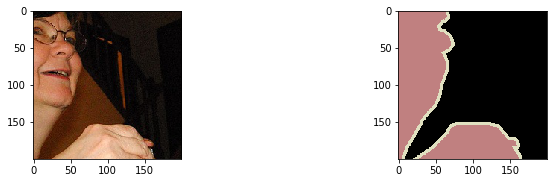

In [0]:
class JointCenterCrop(object):
    def __init__(self, size):
        """
        params:
            size (int) : size of the center crop
        """
        self.size = size
        
    def __call__(self, img, target):
        return (tF.five_crop(img, self.size)[4], 
                tF.five_crop(target, self.size)[4])
    
img, target = JointCenterCrop(200)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)

#### RandomFlip

This class should take a img, target pair and then apply a horizontal flip across the vertical axis at random.


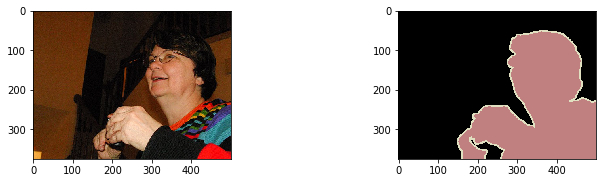

In [0]:
from random import random

class RandomFlip(object):
  
  def __init__(self, prob):
    self.prob = prob
  
  def __call__(self, img, target):
    if random() < self.prob:
      return tF.hflip(img), tF.hflip(target)
    return img, target

img, target = RandomFlip(0.5)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)

#### RandomResizeCrop

This class takes a img, target pair and then resize the images by a random scale between $[\mbox{minimum_scale}, \mbox{maximum_scale}]$, crop a random location of the image by $\min(\mbox{size}, \mbox{image_height}, \mbox{image_width})$ (where the size is passed in as an integer in the constructor), and then resize to $\mbox{size} \times \mbox{size}$ (again, the size passed in). The crop box should fit within the image.

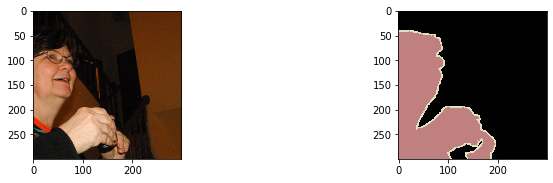

In [0]:
from random import uniform, randint

class RandomResizeCrop(object):

  def __init__(self, size, minimum_scale, maximum_scale):
    self.size = size
    self.scale = uniform(minimum_scale, maximum_scale)

  def __call__(self, img, target):
    width, height = img.size
    img = tF.resize(img, (round(height * self.scale), round(width * self.scale)))
    target = tF.resize(target, (round(height * self.scale), round(width * self.scale)))
    scaled_width, scaled_height = img.size
    size = min(self.size, scaled_height, scaled_width)
    top = randint(0, scaled_height - size)
    left = randint(0, scaled_width - size)
    return tF.resized_crop(img, top, left, size, size, self.size), tF.resized_crop(target, top, left, size, size, self.size)

img, target = RandomResizeCrop(300, 0.8, 0.9)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)

#### Normalize

This class takes a img, target pair and then normalize the images by subtracting the mean and dividing variance. 

In [0]:
norm = ([0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])

class JointNormalize(object):

  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, img, target):
    return tF.normalize(img, self.mean, self.std), target


#### Compose the transforms together: 
##### `JointCompose` composes the implemented transforms together in some random order.

In [0]:
# This class composes transofrmations from a given list of image transforms (expected in the argument). Such compositions 
# will be applied to the dataset during training. 

class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        assert img.size == target.size
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

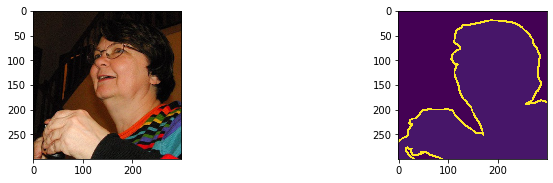

In [0]:
transforms = [RandomResizeCrop(300, 0.9, 1), JointCenterCrop(300), RandomFlip(0.5), JointToTensor()]
img, target = JointCompose(transforms)(*sample1)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(tF.to_pil_image(img))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(target)


#### (e) Compose the transforms together: use `JointCompose` to compose the implemented transforms for:
#### 1. A sanity dataset that will contain 1 single image. The objective is to overfit on this 1 image.
#### 2. A training dataset that will contain the training images. The goal here is to generalize to the validation set, which is unseen.
#### 3. A validation dataset that will contain the validation images. The goal here is to measure the 'true' performance.

In [0]:
sanity_joint_transform = JointCompose([JointToTensor(), JointNormalize(*norm)])

train_joint_transform = JointCompose([RandomResizeCrop(300, 0.9, 1), RandomFlip(0.5), JointToTensor(), JointNormalize(*norm)])

val_joint_transform = JointCompose([JointToTensor(), JointNormalize(*norm)])



This code below will then apply `train_joint_transform` to the entire dataset.

In [0]:
# Apply the Joint-Compose transformations above to create three datasets and the corresponding Data-Loaders.
# Optional integer parameter 'sanity_check' specifies the index of the image-target pair and creates a single image dataset.
# Note that we use the same image (index=200) as used for sample1.
sanity_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train',
    transforms = sanity_joint_transform,
    sanity_check = 200
)

# This is a standard VOC data(sub)set used for training semantic segmentation networks
train_data = VOCSegmentation(
    DATASET_PATH, 
    image_set = 'train', 
    transforms = train_joint_transform
)

# This is a standard VOC data(sub)set used for validating semantic segmentation networks
val_data = VOCSegmentation(
    DATASET_PATH, 
    image_set='val',
    transforms = val_joint_transform
)

# Increase TRAIN_BATCH_SIZE if you are using GPU to speed up training. 
# When batch size changes, the learning rate may also need to be adjusted. 
# Note that batch size maybe limited by your GPU memory, so adjust if you get "run out of GPU memory" error.
TRAIN_BATCH_SIZE = 4

# If you are NOT using Windows, set NUM_WORKERS to anything you want, e.g. NUM_WORKERS = 4,
# but Windows has issues with multi-process dataloaders, so NUM_WORKERS must be 0 for Windows.
NUM_WORKERS = 4

sanity_loader = DataLoader(sanity_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

#### Implement encoder/decoder segmentation CNN using PyTorch.



In [0]:
import torchvision.models as models

class MyNet(nn.Module):
    def __init__(self, num_classes, criterion=None):
        super(MyNet, self).__init__()
        resnet_model = models.resnet18(pretrained=True)
        self.layer_0 = nn.Sequential(
                        resnet_model.conv1,
                        resnet_model.bn1,
                        resnet_model.relu,
                        resnet_model.maxpool)
        
        self.layer_1 = resnet_model.layer1
        self.layer_2 = resnet_model.layer2
        self.layer_3 = resnet_model.layer3
        self.layer_4 = resnet_model.layer4

        self.conv_1 = nn.Conv2d(in_channels=576, out_channels=300, kernel_size=3, padding=1)
        self.b_n_1 = nn.BatchNorm2d(300)
        self.conv_2 = nn.Conv2d(in_channels=300, out_channels=num_classes, kernel_size=3, padding=1)
        self.b_n_2 = nn.BatchNorm2d(num_classes)
    
    def forward(self, inp, gts=None):
        h_inp, w_inp = inp.shape[-2:]
        enc_out = self.layer_0(inp)
        res_out = self.layer_1(enc_out)
        h_res_out, w_res_out = res_out.shape[-2:]
        enc_out = self.layer_2(res_out)
        enc_out = self.layer_3(enc_out)
        enc_out = self.layer_4(enc_out)
        h_enc_out, w_enc_out = enc_out.shape[-2:]
        
        dec_out = F.interpolate(enc_out, size=(h_res_out, w_res_out), mode='bilinear', align_corners=True)
        dec_out = torch.cat((dec_out, res_out), dim=1)
        dec_out = F.relu(self.b_n_1(self.conv_1(dec_out)))
        dec_out = F.relu(self.b_n_2(self.conv_2(dec_out)))
        lfinal = F.interpolate(dec_out, size=(h_inp, w_inp), mode='bilinear', align_corners=True)

        if self.training:
            # Return the loss if in training mode
            return self.criterion(lfinal, gts)              
        else:
            # Return the actual prediction otherwise
            return lfinal
    
    def compute_paddings(self, stride, in_size, out_size):
        div, rem = divmod(in_size * stride - out_size, 2)
        padding = div if rem == 0 else div + 1
        out_padding = rem
        return padding, out_padding

#### Create UNTRAINED_NET and run on a sample image

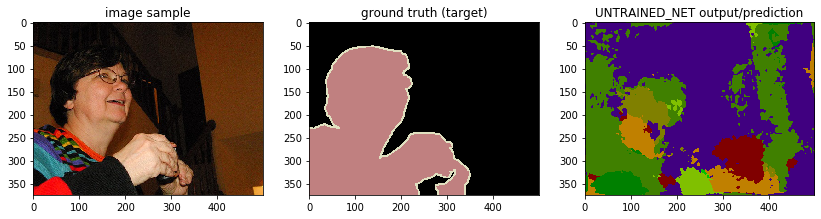

In [0]:
untrained_net = MyNet(21).eval()
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
untrained_output = untrained_net.forward(sample_img[None])

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,3,1)
plt.title('image sample')
ax.imshow(sample1[0])
ax = fig.add_subplot(1,3,2)
plt.title('ground truth (target)')
ax.imshow(sample1[1])
ax = fig.add_subplot(1,3,3)
plt.title('UNTRAINED_NET output/prediction')
ax.imshow(colorize_mask(torch.argmax(untrained_output, dim=1).numpy()[0]))

#### Implement the loss function (Cross Entropy Loss).

In [0]:
class MyCrossEntropyLoss():
    def __init__(self, ignore_index):
        self.ignore_index = ignore_index
    def __call__(self, lfinal, gts):
      return F.nll_loss(input=F.log_softmax(lfinal, dim=1), target=gts, ignore_index=self.ignore_index)


#### Compare against the existing CrossEntropyLoss function on the sample output from the neural network.

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=255)

print(criterion(untrained_output, sample_target[None]))

my_criterion = MyCrossEntropyLoss(ignore_index=255)

print(my_criterion(untrained_output, sample_target[None]))

tensor(3.0988, grad_fn=<NllLoss2DBackward>)
tensor(3.0988, grad_fn=<NllLoss2DBackward>)


#### Use standard function `eval_semantic_segmentation` (already imported from chainerCV) to compute "mean intersection over union" for the output of UNTRAINED_NET on sample1 (`untrained_output`) using the target for sample1.

In [0]:
pred = torch.argmax(untrained_output, dim=1).numpy()
gts = sample_target.numpy()[None]
gts = np.where(gts == 255, -1, gts)

conf = eval_semantic_segmentation(pred, gts)

print("mIoU for the sample image / ground truth pair: {}".format(conf['miou']))

mIoU for the sample image / ground truth pair: 9.236190057815792e-05


/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


#### Validation loop.

In [0]:
def validate(val_loader, net):
    
    iou_arr = []
    net.eval()
    val_loss = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
        
            inputs, masks = data

            if USE_GPU:
                inputs = inputs.cuda()
                masks = masks.cuda()
                net = net.cuda()

            output = net(inputs)
            val_loss += criterion(output, masks).item()
            preds = torch.argmax(output, dim=1).cpu().numpy()
            gts = masks.cpu().numpy()
            gts = np.where(gts == 255, -1, gts)

            conf = eval_semantic_segmentation(preds, gts)

            iou_arr.append(conf['miou'])
    
    return val_loss, (sum(iou_arr) / len(iou_arr))

#### Run the validation loop for UNTRAINED_NET against the sanity validation dataset.

In [0]:
%%time
print("mIoU over the sanity dataset:{}".format(validate(sanity_loader, untrained_net)[1]))

mIoU over the sanity dataset:9.236190057815792e-05
CPU times: user 2.67 s, sys: 1.19 s, total: 3.86 s
Wall time: 6.91 s


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


#### Define an optimizer to train the given loss function.


In [0]:
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.5, weight_decay=1e-5)
    return optimizer




#### Training loop to train the network. 


In [0]:
def train(train_loader, net, optimizer, loss_graph):
    
    for i, data in enumerate(train_loader):
        
        inputs, masks = data

        if USE_GPU:
            inputs = inputs.cuda()
            net = net.cuda()
            masks = masks.cuda()

        optimizer.zero_grad()
        main_loss = net(inputs, gts=masks)
        loss_graph.append(main_loss.item())
        main_loss.backward()
        optimizer.step()
        
    return main_loss

#### Create OVERFIT_NET and train it on the single image dataset.
##### Single image training is helpful for debugging and hyper-parameter tuning (e.g. learning rate, etc.) as it is fast even on a single CPU.

Starting Training...
Epoch: 0 Loss: 3.1425771713256836
Epoch: 1 Loss: 2.7665481567382812
Epoch: 2 Loss: 2.5984020233154297
Epoch: 3 Loss: 2.385267972946167
Epoch: 4 Loss: 2.2602920532226562
Epoch: 5 Loss: 2.0255637168884277
Epoch: 6 Loss: 1.8639112710952759
Epoch: 7 Loss: 1.7031973600387573
Epoch: 8 Loss: 1.5603646039962769
Epoch: 9 Loss: 1.4318891763687134
Epoch: 10 Loss: 1.3132805824279785
Epoch: 11 Loss: 1.2054400444030762
Epoch: 12 Loss: 1.108540415763855
Epoch: 13 Loss: 1.025210976600647
Epoch: 14 Loss: 0.9638575911521912
Epoch: 15 Loss: 0.9330090284347534
Epoch: 16 Loss: 0.8544366359710693
Epoch: 17 Loss: 0.7575674057006836
Epoch: 18 Loss: 0.7065858840942383
Epoch: 19 Loss: 0.652121365070343
Epoch: 20 Loss: 0.6077526211738586
Epoch: 21 Loss: 0.5686773061752319
Epoch: 22 Loss: 0.5330858826637268
Epoch: 23 Loss: 0.5015533566474915
Epoch: 24 Loss: 0.4730491638183594
Epoch: 25 Loss: 0.4474376142024994
Epoch: 26 Loss: 0.42418983578681946
Epoch: 27 Loss: 0.40280604362487793
Epoch: 28 L

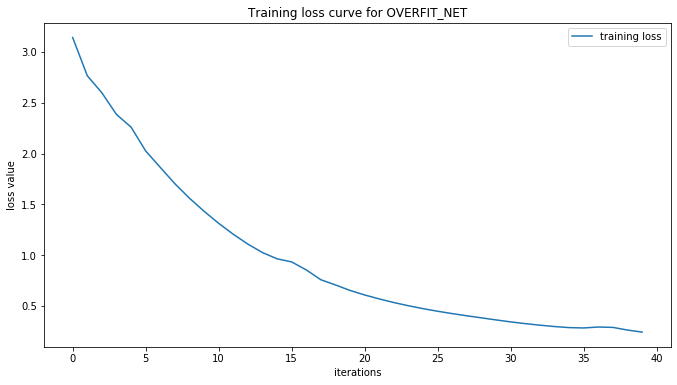

In [0]:
%%time
%matplotlib notebook
%matplotlib inline

# The whole training on a single image (20-40 epochs) should take only a minute or two on a CPU (and a few seconds on GPU). 
# Below we create a (deep) copy of untrained_net and train it on a single training image (leading to gross overfitting).
# Later, we will create a separate (deep) copy of untrained_net to be trained on full training dataset.
# NOTE: Normally, one can create a new net via declaration new_net = MyNet(21). But, randomization of weights when new nets 
# are declared that way creates *different* untrained nets. This notebook compares different versions of network training. 
# For this comparison to be direct and fair, it is better to train (deep) copies of the exact same untrained_net. 
overfit_net = copy.deepcopy(untrained_net)

# set loss function for the net
overfit_net.criterion = nn.CrossEntropyLoss(ignore_index=255)

# set the number of EPOCHS
EPOCH = 40

# switch to train mode (original untrained_net was set to eval mode)
overfit_net.train()

optimizer = get_optimizer(overfit_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(sanity_loader, overfit_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for OVERFIT_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))


#### Qualitative and quantitative evaluation of predictions (untrained vs overfit nets)

/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


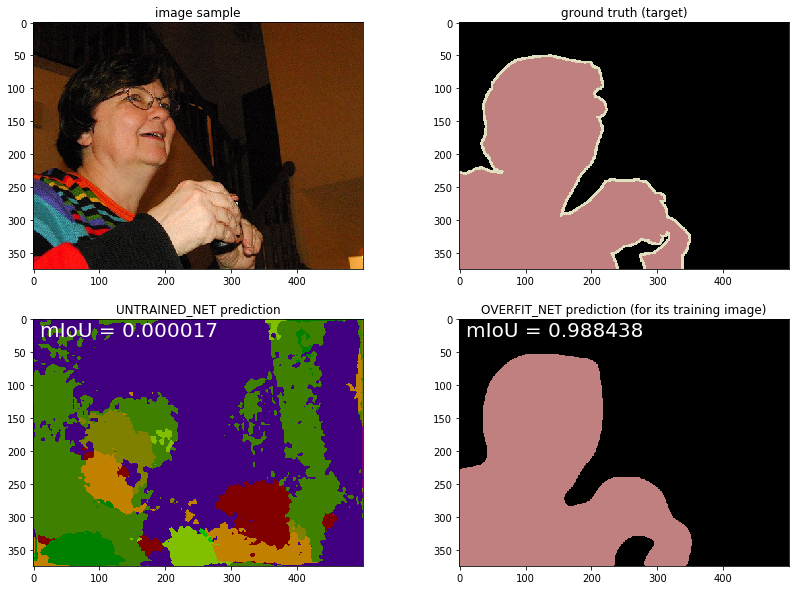

In [0]:
# switch back to evaluation mode
overfit_net.eval()

sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_U = untrained_net.cuda().forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
if USE_GPU:
    pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]
else:
    pred_O = torch.argmax(sample_output_O, dim=1).numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).numpy()[0]

gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_U = eval_semantic_segmentation(pred_U[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample1[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample1[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('UNTRAINED_NET prediction')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_U['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('OVERFIT_NET prediction (for its training image)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))

/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


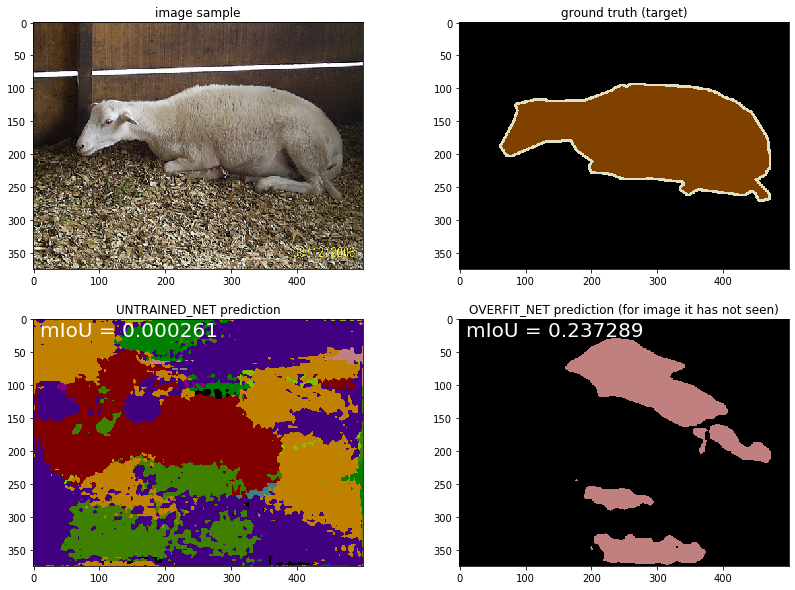

In [0]:
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample2))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_U = untrained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
if USE_GPU:
    pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]
else:
    pred_O = torch.argmax(sample_output_O, dim=1).numpy()[0]
    pred_U = torch.argmax(sample_output_U, dim=1).numpy()[0]

gts = torch.from_numpy(np.array(sample2[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_U = eval_semantic_segmentation(pred_U[None], gts[None])

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample2[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample2[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('UNTRAINED_NET prediction')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_U['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_U, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))

#### Run the validation loop for OVERFIT_NET against the sanity dataset (an image it was trained on)

In [0]:
%%time
print("mIoU for OVERFIT_NET over its training image:{}".format(validate(sanity_loader, overfit_net)[1]))

mIoU for OVERFIT_NET over its training image:0.9916392276108174
CPU times: user 28.1 ms, sys: 185 ms, total: 213 ms
Wall time: 360 ms


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


#### Evaluate UNTRAINED_NET and OVERFIT_NET on validation dataset.
##### Run the validation loop for UNTRAINED_NET against the validation dataset:

In [0]:
%%time
# This will be slow on CPU (around 1 hour or more). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for UNTRAINED_NET over the entire dataset:{}".format(validate(val_loader, untrained_net)[1]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


mIoU for UNTRAINED_NET over the entire dataset:0.0017644491205668228
CPU times: user 27 s, sys: 3.82 s, total: 30.8 s
Wall time: 32.8 s


##### Run the validation loop for OVERFIT_NET against the validation dataset (it has not seen): 

In [0]:
%%time
# This will be slow on CPU (around 1 hour or more). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for OVERFIT_NET over the validation dataset:{}".format(validate(val_loader, overfit_net)[1]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


mIoU for OVERFIT_NET over the validation dataset:0.2833733217256636
CPU times: user 27.8 s, sys: 3.9 s, total: 31.7 s
Wall time: 33.4 s


#### Some observations of the above quantitative results:

From the training loss curve above, we observed that the overfit net converges quickly and steadily, and it ends up with a tiny training loss (~ 0.24). As a result, the mIoU for this single training sample is very high (0.99). However, when it comes to unseen samples (e.g. sample2), we saw a great degradation in performance (mIoU reduces to 0.24), which is the sign of overfitting. The overfitted network puts great emphasis on learning the exact low-level patterns of the training set. Consequently, it cannot generalize well on validation set since it is not capable of extracting high-level semantic meanings in general. Moreover, the overfit net in this case is highly biased. Its prediction on sample2 reveals that it can only recongize human and background beacuse the overfit net has never seen any other categories than those. 

When we evaluate and compare the performance between overfit net and untrained net against the entire validation set. It turns out that the overfit net outperforms the untrained net (0.282 vs 0.002). Untrained net is composed of randomly initialized weights, whereas overfit net has learnt some pattern of human, which might help it to predict other samples with human. Therefore, the quantitative results are reasonable and expected.


#### (f) Create TRAINED_NET and train it on the full training dataset:

Starting Training...
Epoch: 0 Loss: 1.6249421834945679
Epoch: 1 Loss: 1.4226089715957642
Epoch: 2 Loss: 1.030776023864746
Epoch: 3 Loss: 1.152695655822754
Epoch: 4 Loss: 0.510844349861145
Epoch: 5 Loss: 0.6988333463668823
CPU times: user 1min 24s, sys: 15.7 s, total: 1min 40s
Wall time: 2min 9s


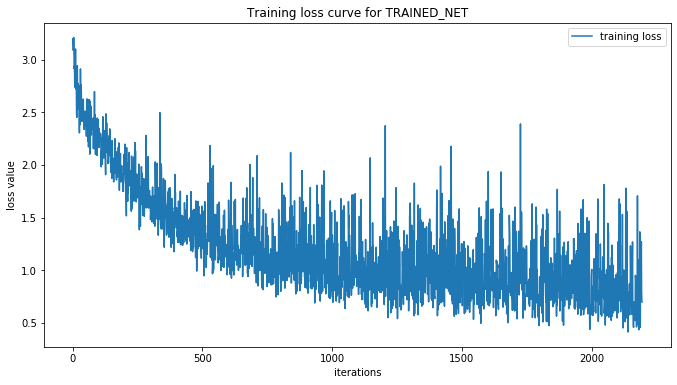

In [0]:
%%time
%matplotlib notebook
%matplotlib inline

# This training will be very slow on a CPU (>1hour per epoch). Ideally, this should be run in GPU mode (USE_GPU=True) 
# taking only a few minutes per epoch (depending on your GPU and batch size). 
trained_net = copy.deepcopy(untrained_net)

# set loss function for the net
trained_net.criterion = nn.CrossEntropyLoss(ignore_index=255)


# You can change the number of EPOCHS below. Since each epoch for TRAINED_NET iterates over all training dataset images,
# the number of required epochs could be smaller compared to OFERFIT_NET where each epoch iterates over one-image-dataset)
EPOCH = 6

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

optimizer = get_optimizer(trained_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_loader, trained_net, optimizer, loss_graph)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for TRAINED_NET')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()    
    print("Epoch: {} Loss: {}".format(e, loss))


#### (g) Qualitative and quantitative evaluation of predictions (OVERFIT_NET vs TRAINED_NET):

/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


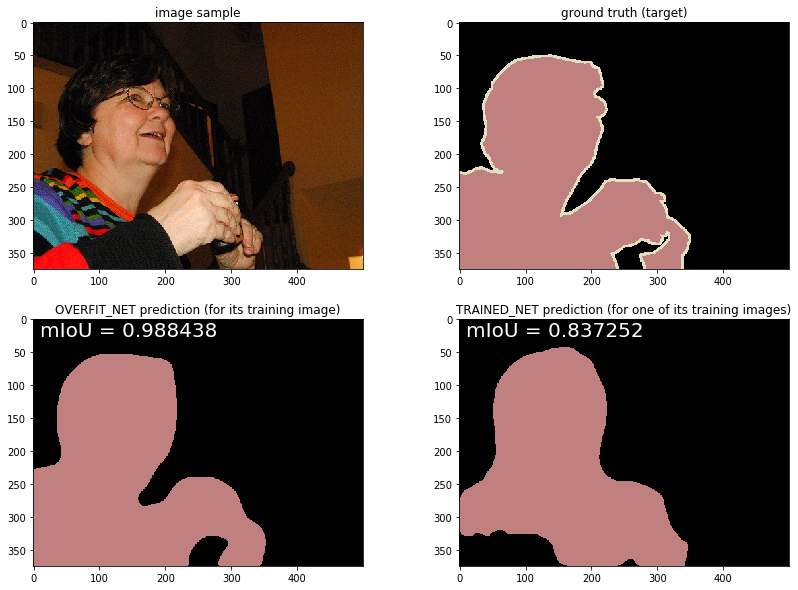

In [0]:
# switch back to evaluation mode
trained_net.eval()

sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample1))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
gts = torch.from_numpy(np.array(sample1[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample1[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample1[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for its training image)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for one of its training images)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


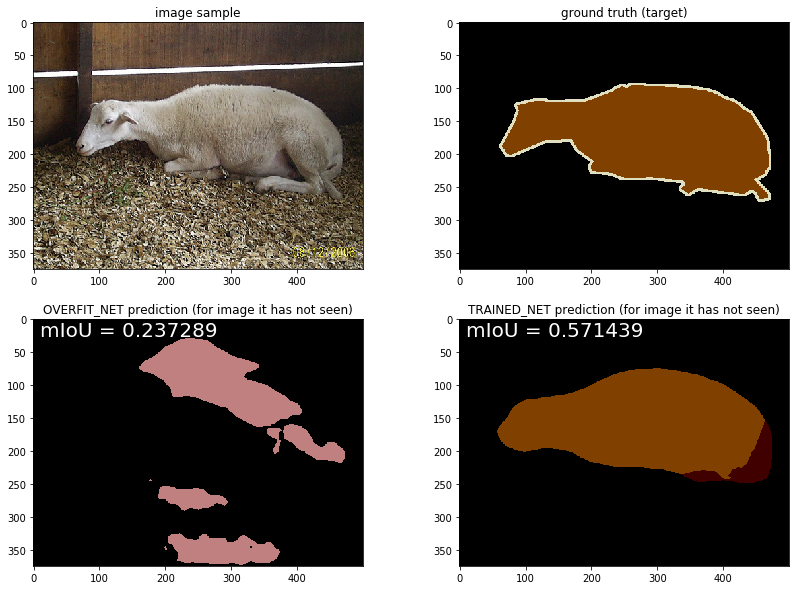

In [0]:
sample_img, sample_target = JointNormalize(*norm)(*JointToTensor()(*sample2))
if USE_GPU:
    sample_img = sample_img.cuda()
sample_output_O = overfit_net.forward(sample_img[None])
sample_output_T = trained_net.forward(sample_img[None])

# computing mIOU (quantitative measure of accuracy for network predictions)
pred_O = torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]
pred_T = torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]
gts = torch.from_numpy(np.array(sample2[1].convert('P'), dtype=np.int32)).long().numpy()
gts[gts == 255] = -1
conf_O = eval_semantic_segmentation(pred_O[None], gts[None])
conf_T = eval_semantic_segmentation(pred_T[None], gts[None])


fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
plt.title('image sample')
ax1.imshow(sample2[0])
ax2 = fig.add_subplot(2,2,2)
plt.title('ground truth (target)')
ax2.imshow(sample2[1])
ax3 = fig.add_subplot(2,2,3)
plt.title('OVERFIT_NET prediction (for image it has not seen)')
ax3.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_O['miou']), fontsize=20, color='white')
ax3.imshow(colorize_mask(torch.argmax(sample_output_O, dim=1).cpu().numpy()[0]))
ax4 = fig.add_subplot(2,2,4)
plt.title('TRAINED_NET prediction (for image it has not seen)')
ax4.text(10, 25, 'mIoU = {:_>8.6f}'.format(conf_T['miou']), fontsize=20, color='white')
ax4.imshow(colorize_mask(torch.argmax(sample_output_T, dim=1).cpu().numpy()[0]))

#### (h) Evaluate TRAINED_NET on validation dataset.
##### Run the validation loop for TRAINED_NET against the validation dataset (it has not seen): 

In [0]:
%%time
# This will be slow on CPU (around 1 hour). On GPU it should take only a few minutes (depending on your GPU).
print("mIoU for TRAINED_NET over the validation dataset:{}".format(validate(val_loader, trained_net)[1]))

/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


mIoU for TRAINED_NET over the validation dataset:0.44504805714933027
CPU times: user 26.3 s, sys: 3.72 s, total: 30.1 s
Wall time: 31.6 s


#### Limitations / Bottlenecks:

Overall, the proposed network approach yields fairly good results considering its simple and compact architecture. By exploiting GPU acceleration, the training time for five epoches is reduced to around 2 minutes. The evaluation against the validation substantially improved from ~0,28 mIoU in overfit_net to ~0.45 mIoU in train_net, which illustrates its ability in generality.

Due to properties of the convolutional neural networks, the kernels provide narraw field of view to the input, which brings them huge advantages of extracting local features and making predictions based on that. For semantic segmentation, however, we also need to pay attention to the global context as a whole. If we look at the prediction for sample2, we could observe some mislabelling happening near the rear side of the sheep even though pixels look indifferent across the boundary. We might argue that this aritifact is a result of lacking interactions between pixels.

Further improvements can be done by introducing some prior knowledges, for instance, photo-consistency and spatial consistency. The ituition behind photo-consistency is that, by assuming objects in same category is likely to share similar histogram / distribtuon, pixels with the same label tend to show high likelihood with the histogram / distribtuon associated with this particular category. Spatial consistency serves as a regularization term which penalize the changes in labeling between neighbouring pixels over low variant reigons. In practice, people realize these concepts by implenenting a fully-connected CRF as a post-processing technique.
